# Core v2 — Otimização de Modelos com Algoritmo Genético (PyGAD)

Este notebook é uma evolução do `core.ipynb`.  
Objetivo: **otimizar os hiperparâmetros do RandomForestClassifier** utilizando um **Algoritmo Genético (PyGAD)** e comparar os resultados com o modelo baseline.

ETAPA 1 - Importação das bibliotecas

In [13]:
import numpy as np
import pygad
import os
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_breast_cancer
from openai import OpenAI


# Carregar dataset
X, y = load_breast_cancer(return_X_y=True)

In [14]:
# Modelo baseline (RandomForest sem ajuste de hiperparâmetros)
baseline_model = RandomForestClassifier(random_state=42)
baseline_f1 = cross_val_score(baseline_model, X, y, cv=5, scoring="f1").mean()

print(f"Baseline RandomForest (default) - F1 médio (CV=5): {baseline_f1:.4f}")


Baseline RandomForest (default) - F1 médio (CV=5): 0.9652


In [15]:
# Função fitness: recebe genes = hiperparâmetros e retorna F1 médio (CV=5)
def fitness_func(ga_instance, solution, solution_idx):
    n_estimators = int(solution[0])
    max_depth = int(solution[1])
    min_samples_split = int(solution[2])

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth if max_depth > 0 else None,
        min_samples_split=min_samples_split,
        random_state=42
    )

    scores = cross_val_score(model, X, y, cv=5, scoring="f1")
    return np.mean(scores)

In [16]:
# Espaço de busca (limites de cada hiperparâmetro)
gene_space = [
    range(50, 301),   # n_estimators
    range(1, 31),     # max_depth
    range(2, 21)      # min_samples_split
]

# Instância do GA
ga = pygad.GA(
    num_generations=12,        # número de gerações
    num_parents_mating=6,      # pais usados no crossover
    fitness_func=fitness_func, # função de avaliação
    sol_per_pop=16,            # tamanho da população
    num_genes=len(gene_space), # número de hiperparâmetros
    gene_space=gene_space,
    mutation_probability=0.15, # taxa de mutação
    crossover_probability=0.9, # taxa de crossover
    allow_duplicate_genes=False
)

In [17]:
# Executar a otimização
ga.run()

# Recuperar melhor solução
best_solution, best_fitness, best_idx = ga.best_solution()
print("Melhores hiperparâmetros encontrados:", best_solution)
print(f"Melhor F1 médio (CV=5) via GA: {best_fitness:.4f}")

Melhores hiperparâmetros encontrados: [111.  22.   7.]
Melhor F1 médio (CV=5) via GA: 0.9709


=== Comparação de F1 médio (CV=5) ===
Baseline RandomForest: 0.9652
GA Otimizado:          0.9709


C:\Users\contv\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pygad\visualize\plot.py:120: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  matplt.legend()


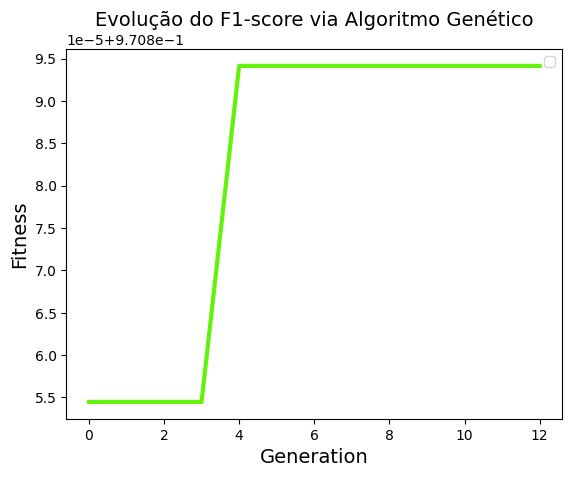

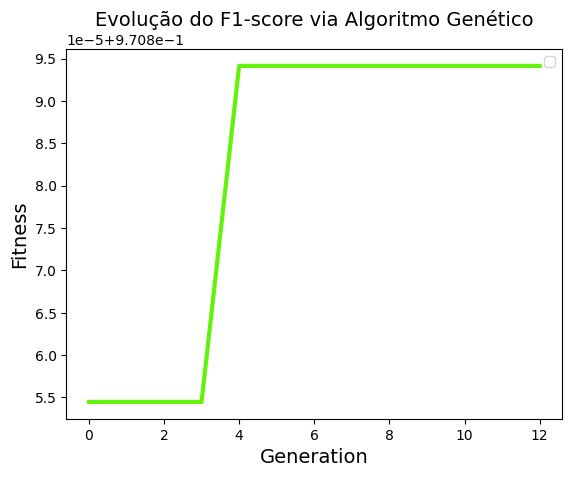

In [18]:
# Modelo otimizado via GA
best_model = RandomForestClassifier(
    n_estimators=int(best_solution[0]),
    max_depth=int(best_solution[1]),
    min_samples_split=int(best_solution[2]),
    random_state=42
)

best_f1 = cross_val_score(best_model, X, y, cv=5, scoring="f1").mean()

print("=== Comparação de F1 médio (CV=5) ===")
print(f"Baseline RandomForest: {baseline_f1:.4f}")
print(f"GA Otimizado:          {best_f1:.4f}")
ga.plot_fitness(title="Evolução do F1-score via Algoritmo Genético")


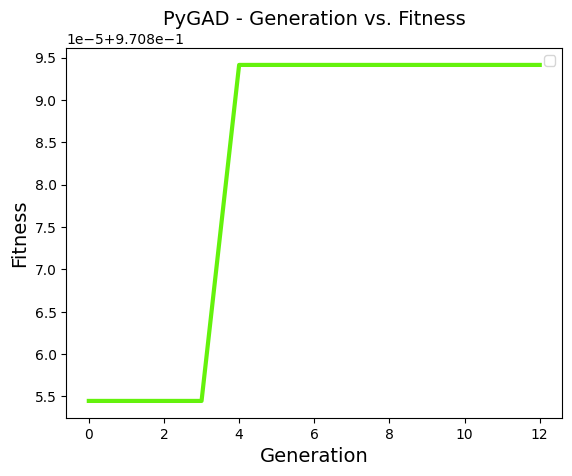

In [19]:
# Plot da evolução do fitness por geração
try:
    ga.plot_fitness()
except Exception as e:
    print("Se o plot não aparecer, está tudo bem. Erro:", e)

In [22]:
# Criar cliente da OpenAI (certifique-se de definir a chave no ambiente)
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

def gerar_explicacao(hiperparams, baseline_f1, best_f1):
    prompt = f"""
    Você é um assistente médico de IA.  
    Um modelo de RandomForest foi otimizado via Algoritmo Genético.  
    - Hiperparâmetros escolhidos: {hiperparams}  
    - F1 baseline: {baseline_f1:.4f}  
    - F1 otimizado: {best_f1:.4f}  

    Explique em português, de forma clara e acessível para médicos,  
    o que esses resultados significam na prática clínica.
    """
    
    resposta = client.chat.completions.create(
        model="gpt-4o-mini",   # pode trocar para "gpt-4o" se tiver acesso
        messages=[{"role": "user", "content": prompt}],
        max_tokens=300
    )
    return resposta.choices[0].message.content

# Chamar função e gerar explicação automática
explicacao = gerar_explicacao(best_solution, baseline_f1, best_f1)
print("=== Explicação em linguagem natural ===\n")
print(explicacao)

OpenAIError: The api_key client option must be set either by passing api_key to the client or by setting the OPENAI_API_KEY environment variable